In [2]:
import cv2
import mediapipe as mp
import dataclasses
from tqdm import tqdm
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_pose = mp.solutions.pose

In [3]:
import enum

class PoseLandmark(enum.IntEnum):
    """The 33 pose landmarks."""
    NOSE = 0
    LEFT_EYE_INNER = 1
    LEFT_EYE = 2
    LEFT_EYE_OUTER = 3
    RIGHT_EYE_INNER = 4
    RIGHT_EYE = 5
    RIGHT_EYE_OUTER = 6
    LEFT_EAR = 7
    RIGHT_EAR = 8
    MOUTH_LEFT = 9
    MOUTH_RIGHT = 10
    LEFT_SHOULDER = 11
    RIGHT_SHOULDER = 12
    LEFT_ELBOW = 13
    RIGHT_ELBOW = 14
    LEFT_WRIST = 15
    RIGHT_WRIST = 16
    LEFT_PINKY = 17
    RIGHT_PINKY = 18
    LEFT_INDEX = 19
    RIGHT_INDEX = 20
    LEFT_THUMB = 21
    RIGHT_THUMB = 22
    LEFT_HIP = 23
    RIGHT_HIP = 24
    LEFT_KNEE = 25
    RIGHT_KNEE = 26
    LEFT_ANKLE = 27
    RIGHT_ANKLE = 28
    LEFT_HEEL = 29
    RIGHT_HEEL = 30
    LEFT_FOOT_INDEX = 31
    RIGHT_FOOT_INDEX = 32
    
BODY_LANDMARKS = [
    PoseLandmark.LEFT_SHOULDER,
    PoseLandmark.RIGHT_SHOULDER,
    PoseLandmark.LEFT_ELBOW,
    PoseLandmark.RIGHT_ELBOW,
    PoseLandmark.LEFT_WRIST,
    PoseLandmark.RIGHT_WRIST,
    PoseLandmark.LEFT_HIP,
    PoseLandmark.RIGHT_HIP,
    PoseLandmark.LEFT_KNEE,
    PoseLandmark.RIGHT_KNEE,
    PoseLandmark.LEFT_ANKLE,
    PoseLandmark.RIGHT_ANKLE,
]

RIGHT_BODY_LANDMARKS = [
    PoseLandmark.RIGHT_SHOULDER,
    PoseLandmark.RIGHT_ELBOW,
    PoseLandmark.RIGHT_WRIST,
    PoseLandmark.RIGHT_HIP,
    PoseLandmark.RIGHT_KNEE,
    PoseLandmark.RIGHT_ANKLE,
]

LEFT_BODY_LANDMARKS = [
    PoseLandmark.LEFT_SHOULDER,
    PoseLandmark.LEFT_ELBOW,
    PoseLandmark.LEFT_WRIST,
    PoseLandmark.LEFT_HIP,
    PoseLandmark.LEFT_KNEE,
    PoseLandmark.LEFT_ANKLE,
]

POSE_CONNECTIONS = frozenset([(0, 1), (1, 2), (2, 3), (3, 7), (0, 4), (4, 5),
                              (5, 6), (6, 8), (9, 10), (11, 12), (11, 13),
                              (13, 15), (15, 17), (15, 19), (15, 21), (17, 19),
                              (12, 14), (14, 16), (16, 18), (16, 20), (16, 22),
                              (18, 20), (11, 23), (12, 24), (23, 24), (23, 25),
                              (24, 26), (25, 27), (26, 28), (27, 29), (28, 30),
                              (29, 31), (30, 32), (27, 31), (28, 32)])

BODY_CONNECTIONS = [
    (PoseLandmark.LEFT_SHOULDER, PoseLandmark.RIGHT_SHOULDER),
    (PoseLandmark.LEFT_SHOULDER, PoseLandmark.LEFT_ELBOW),
    (PoseLandmark.LEFT_ELBOW, PoseLandmark.LEFT_WRIST),
    (PoseLandmark.RIGHT_SHOULDER, PoseLandmark.RIGHT_ELBOW),
    (PoseLandmark.RIGHT_ELBOW, PoseLandmark.RIGHT_WRIST),
    (PoseLandmark.LEFT_SHOULDER, PoseLandmark.LEFT_HIP),
    (PoseLandmark.RIGHT_SHOULDER, PoseLandmark.RIGHT_HIP),
    (PoseLandmark.LEFT_HIP, PoseLandmark.RIGHT_HIP),
    (PoseLandmark.LEFT_HIP, PoseLandmark.LEFT_KNEE),
    (PoseLandmark.RIGHT_HIP, PoseLandmark.RIGHT_KNEE),
    (PoseLandmark.LEFT_KNEE, PoseLandmark.LEFT_ANKLE),
    (PoseLandmark.RIGHT_KNEE, PoseLandmark.RIGHT_ANKLE)
]

_PRESENCE_THRESHOLD = 0.5
_VISIBILITY_THRESHOLD = 0.5
_BGR_CHANNELS = 3

WHITE_COLOR = (224, 224, 224)
BLACK_COLOR = (0, 0, 0)
RED_COLOR = (0, 0, 255)
GREEN_COLOR = (0, 220, 0)
BLUE_COLOR = (255, 0, 0)

In [16]:
from mediapipe.framework.formats import landmark_pb2
from typing import List, Mapping, Optional, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import math
import io


@dataclasses.dataclass
class DrawingSpec:
    # Color for drawing the annotation. Default to the white color.
    color: Tuple[int, int, int] = WHITE_COLOR
    # Thickness for drawing the annotation. Default to 2 pixels.
    thickness: int = 2
    # Circle radius. Default to 2 pixels.
    circle_radius: int = 2

def normalize_color(color):
    return tuple(v / 255. for v in color)

def horizontal_angle(x1, y1, x2, y2): 
    if (y1 == y2):
        return 0.0;
    
    a = (abs(y2 - y1)/abs(x2 - x1))
    
    return math.degrees(math.atan(a))

def vertical_angle(x1, y1, x2, y2): 
    if (x1 == x2):
        return 0.0;
    
    a = (abs(x2 - x1)/abs(y2 - y1))
    
    return math.degrees(math.atan(a))

def normalized_to_pixel_coordinates(
    normalized_x: float,
    normalized_y: float,
    image_width: int,
    image_height: int) -> Union[None, Tuple[int, int]]:
    """Converts normalized value pair to pixel coordinates."""

      # Checks if the float value is between 0 and 1.
    def is_valid_normalized_value(value: float) -> bool:
        return (value > 0 or math.isclose(0, value)) and (value < 1 or math.isclose(1, value))

    if not (is_valid_normalized_value(normalized_x) and is_valid_normalized_value(normalized_y)):
        return None
    x_px = min(math.floor(normalized_x * image_width), image_width - 1)
    y_px = min(math.floor(normalized_y * image_height), image_height - 1)
    return x_px, y_px

def draw_body_landmarks(
        landmark_list: landmark_pb2.NormalizedLandmarkList,
        landmark_drawing_spec: DrawingSpec,
        ax, 
        plotted_landmarks): 
    
    landmarks_dict = landmark_list.landmark
    left_ankle = landmarks_dict[PoseLandmark.LEFT_ANKLE]
    right_ankle = landmarks_dict[PoseLandmark.RIGHT_ANKLE]
    
    right_delta = -1.0 +right_ankle.y
    left_delta = -1.0 + left_ankle.y
    
    for body_landmark_id in BODY_LANDMARKS:
        landmark = landmark_list.landmark[body_landmark_id]
        if ((landmark.HasField('visibility') and
             landmark.visibility < _VISIBILITY_THRESHOLD) or
            (landmark.HasField('presence') and
             landmark.presence < _PRESENCE_THRESHOLD)):
            continue
        is_left_body_landmark = body_landmark_id in LEFT_BODY_LANDMARKS 
        vertical_pos = -landmark.y + left_delta if is_left_body_landmark else -landmark.y + right_delta
        ax.scatter3D(
            xs=[-landmark.z],
            ys=[landmark.x],
            zs=[vertical_pos],
            color=normalize_color(landmark_drawing_spec.color[::-1]),
            linewidth=landmark_drawing_spec.thickness)
        plotted_landmarks[body_landmark_id] = (-landmark.z, landmark.x, vertical_pos)
    
def draw_connections(connection_drawing_spec: DrawingSpec, ax, plotted_landmarks):
    for connection in BODY_CONNECTIONS:
        start_idx = connection[0]
        end_idx = connection[1]
        if start_idx in plotted_landmarks and end_idx in plotted_landmarks:
            landmark_pair = [plotted_landmarks[start_idx], plotted_landmarks[end_idx]]
        ax.plot3D(
            xs=[landmark_pair[0][0], landmark_pair[1][0]],
            ys=[landmark_pair[0][1], landmark_pair[1][1]],
            zs=[landmark_pair[0][2], landmark_pair[1][2]],
            color=normalize_color(connection_drawing_spec.color[::-1]),
            linewidth=connection_drawing_spec.thickness)

def plot_landmarks_3d(landmark_list: landmark_pb2.NormalizedLandmarkList,
                   connections: Optional[List[Tuple[int, int]]] = None,
                   landmark_drawing_spec: DrawingSpec = DrawingSpec(color=RED_COLOR, thickness=3),
                   connection_drawing_spec: DrawingSpec = DrawingSpec(color=BLACK_COLOR, thickness=3),
                   elevation: int = 10,
                   azimuth: int = 10,
                   save_path = '',
                   show: bool = False):
    if not landmark_list:
        return
    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes(projection='3d')
    ax.view_init(elev=elevation, azim=azimuth)
    ax.set_anchor('C')
    plotted_landmarks = {}
    draw_body_landmarks(landmark_list, landmark_drawing_spec, ax, plotted_landmarks)

    # add corner points for scene positioning 
    ax.scatter3D(xs=[-1], ys=[-1], zs=[-1], color=normalize_color(WHITE_COLOR), linewidth=1)
    ax.scatter3D(xs=[1], ys=[1], zs=[1], color=normalize_color(WHITE_COLOR), linewidth=1)
    if connections:
        draw_connections(connection_drawing_spec, ax, plotted_landmarks)

    ax.plot3D(xs=[0, 0], ys=[0, 0], zs=[-1, 1], color=normalize_color(GREEN_COLOR), linewidth=1)
    if save_path != '': 
        plt.savefig(save_path, transparent=True)
    if show is True:
        plt.show()
    buf = io.BytesIO()
    fig.savefig(buf, format='png')
    buf.seek(0)
    plt.close()
    plt.clf()
    return buf

def draw_landmarks(
    image: np.ndarray,
    landmark_list: landmark_pb2.NormalizedLandmarkList,
    connections: Optional[List[Tuple[int, int]]] = None,
    landmark_drawing_spec: Union[DrawingSpec,
                                 Mapping[int, DrawingSpec]] = DrawingSpec(
                                     color=GREEN_COLOR),
    connection_drawing_spec: Union[DrawingSpec,
                                   Mapping[Tuple[int, int],
                                           DrawingSpec]] = DrawingSpec(color=GREEN_COLOR)):
    epsilon = 3.0
    if not landmark_list:
        return
    if image.shape[2] != _BGR_CHANNELS:
        raise ValueError('Input image must contain three channel bgr data.')
    image_rows, image_cols, _ = image.shape
    idx_to_coordinates = {}
    for body_landmark_id in BODY_LANDMARKS:
        landmark = landmark_list.landmark[body_landmark_id]
        if ((landmark.HasField('visibility') and
             landmark.visibility < _VISIBILITY_THRESHOLD) or
            (landmark.HasField('presence') and
             landmark.presence < _PRESENCE_THRESHOLD)):
            continue
        landmark_px = normalized_to_pixel_coordinates(landmark.x, landmark.y, image_cols, image_rows)
        if landmark_px:
            idx_to_coordinates[body_landmark_id] = landmark_px
    if connections:
        for connection in BODY_CONNECTIONS:
            start_idx = connection[0]
            end_idx = connection[1]
            if start_idx in idx_to_coordinates and end_idx in idx_to_coordinates:
                drawing_spec = connection_drawing_spec[connection] if isinstance(
                    connection_drawing_spec, Mapping) else connection_drawing_spec
                current_color = drawing_spec.color
                if (start_idx == PoseLandmark.LEFT_SHOULDER and end_idx == PoseLandmark.RIGHT_SHOULDER) or (start_idx == PoseLandmark.LEFT_HIP and end_idx == PoseLandmark.RIGHT_HIP):
                    x1 = idx_to_coordinates[start_idx][0]
                    y1 = idx_to_coordinates[start_idx][1]
                    x2 = idx_to_coordinates[end_idx][0]
                    y2 = idx_to_coordinates[end_idx][1]
                    angle = horizontal_angle(x1, y1, x2, y2)
                    if angle > epsilon:
                        current_color = RED_COLOR
                cv2.line(image, idx_to_coordinates[start_idx],
                         idx_to_coordinates[end_idx], current_color,
                         drawing_spec.thickness)
    # Draws landmark points after finishing the connection lines, which is
    # aesthetically better.
    if landmark_drawing_spec:
        for idx, landmark_px in idx_to_coordinates.items():
            drawing_spec = landmark_drawing_spec[idx] if isinstance(landmark_drawing_spec, Mapping) else landmark_drawing_spec
              # White circle border
            circle_border_radius = max(drawing_spec.circle_radius + 1, int(drawing_spec.circle_radius * 1.2))
            cv2.circle(image, landmark_px, circle_border_radius, WHITE_COLOR, drawing_spec.thickness)
              # Fill color into the circle
            cv2.circle(image, landmark_px, drawing_spec.circle_radius, GREEN_COLOR, drawing_spec.thickness)



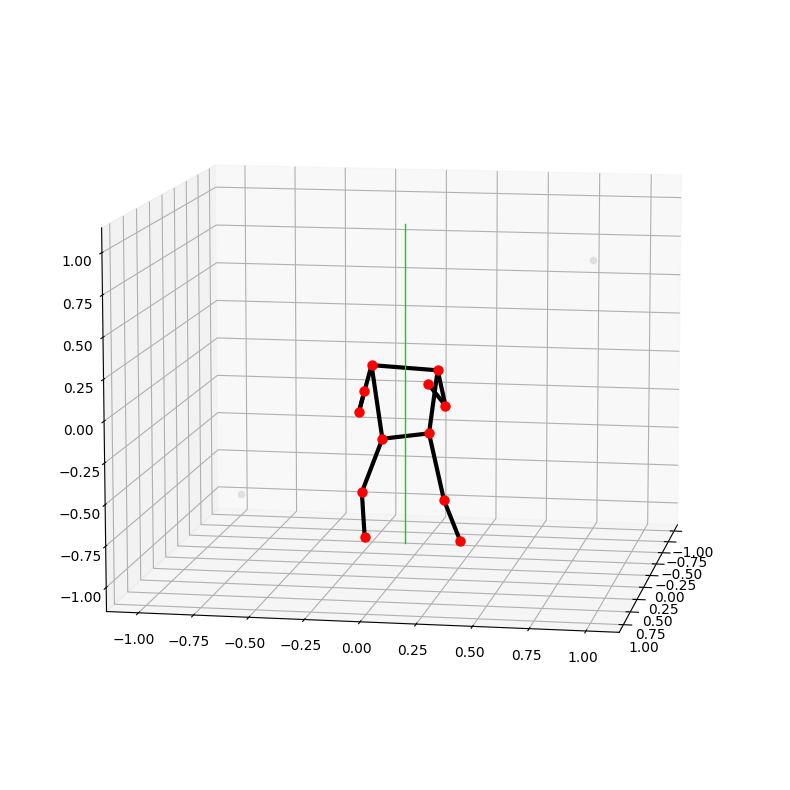

<Figure size 640x480 with 0 Axes>

In [17]:
img_path = './../data/img1.png'
vid_path = './../data/vid1.png'

r = {}
with mp_pose.Pose(
    static_image_mode=True,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5,
    model_complexity=2) as pose:
    image = cv2.imread(img_path)
    results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    r = results
    draw_landmarks(
        image,
        results.pose_landmarks,
        mp_pose.POSE_CONNECTIONS,
        landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
    plt_img = plot_landmarks_3d(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS, show=True, save_path='3dpic.png')
    cv2.imshow("Someimage",image)
    cv2.waitKey(0) 
    cv2.destroyAllWindows() 

In [18]:
def from_video_front(path, save=True):
    cap = cv2.VideoCapture(path)
    res = (480, 640)
    cnt = 1
    frames = 1000
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter('pose_front_low_res.mp4', fourcc, 30.0, res)
    with mp_pose.Pose(
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5,
        model_complexity=2) as pose:
        while cap.isOpened() and cnt < frames:
            for i in tqdm(range(0, frames)):
                success, image = cap.read()
                if not success:
                    break

                image = cv2.flip(image, -1)
                image.flags.writeable = False
                
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                results = pose.process(image)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                image.flags.writeable = True
                image = cv2.resize(image, res)
                draw_landmarks(
                    image,
                    results.pose_landmarks,
                    mp_pose.POSE_CONNECTIONS,
                    landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
                # cv2.imshow('Pose detection', cv2.flip(image, -1))
                if save:
                    out.write(image)
                cnt = cnt + 1
                if cv2.waitKey(5) & 0xFF == 27:
                    break
    cap.release()
    out.release()
    cv2.waitKey(0) 
    cv2.destroyAllWindows() 

In [19]:
from_video_front('./data/videos/vid1.mp4')

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:30<00:00,  3.70it/s]


In [16]:
def from_video_3d(path): 
    cap = cv2.VideoCapture(path)
    cnt = 1
    frames = 1000
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter('pose_ground_fast.mp4', fourcc, 20.0, (480,640))
    with mp_pose.Pose(
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5,
        model_complexity=2) as pose:
        while cap.isOpened() and cnt < frames:
            for i in tqdm(range(0, frames)):
                success, image = cap.read()
                if not success:
                    break

                image = cv2.resize(image, (480, 640))
                image = cv2.flip(image, -1)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                results = pose.process(image)
                plt_img = plot_landmarks(
                    results.pose_world_landmarks,
                    mp_pose.POSE_CONNECTIONS,
                    azimuth=cnt*2)

                plt_img = cv2.imdecode(np.frombuffer(plt_img.getvalue(), dtype=np.uint8), 1)
                out.write(plt_img)
                cnt = cnt + 1
                if cv2.waitKey(5) & 0xFF == 27:
                    break
    cap.release()
    out.release()
    cv2.waitKey(0) 
    cv2.destroyAllWindows() 

In [17]:
from_video_3d('./data/videos/vid1.mp4')

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:21<00:00,  1.23it/s]


<Figure size 640x480 with 0 Axes>